# Benchmark study using Kalman Filter or GARCH Model

In [42]:
import scipy.stats
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as ss

In [43]:
# Download and save Netfilx stock data fron Jan 1, 2020 to Aug 31, 2024
nflx_data = yf.download('NFLX', start = '2020-01-01', end = '2024-08-31')
nflx_data.to_csv('NFLX.csv')

# Display the first few rows
print(nflx_data.head())

[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker            NFLX        NFLX        NFLX        NFLX        NFLX   
Date                                                                     
2020-01-02  329.809998  329.809998  329.980011  324.779999  326.100006   
2020-01-03  325.899994  325.899994  329.859985  325.529999  326.779999   
2020-01-06  335.829987  335.829987  336.359985  321.200012  323.119995   
2020-01-07  330.750000  330.750000  336.700012  330.299988  336.470001   
2020-01-08  339.260010  339.260010  342.700012  331.049988  331.489990   

Price        Volume  
Ticker         NFLX  
Date                 
2020-01-02  4485800  
2020-01-03  3806900  
2020-01-06  5663100  
2020-01-07  4703200  
2020-01-08  7104500  


In [44]:
# Take the Adjusted Closed, caluculate its mean, standard deviation, skewness and kurtosis
nflx_adj_close = nflx_data['Adj Close'].values
print('Mean: ',np.mean(nflx_adj_close))
print('Standard deviation: ',np.std(nflx_adj_close))
print('Skewness: ',ss.skew(nflx_adj_close, axis=0, bias=True))
print('Kurtosis: ',ss.kurtosis(nflx_adj_close, axis=0, bias=True) + 3)

Mean:  447.5047529308313
Standard deviation:  131.93740124252068
Skewness:  [-0.20649821]
Kurtosis:  [2.25730068]


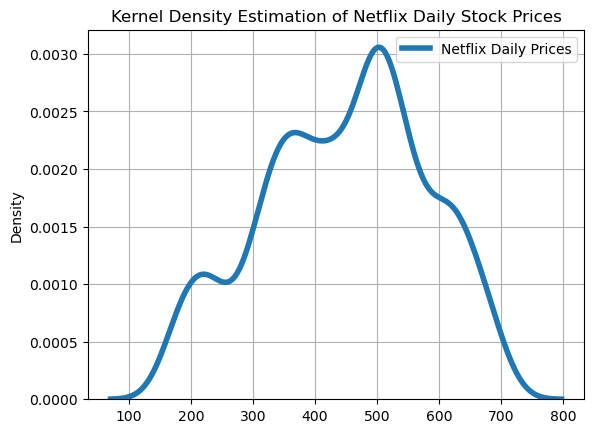

In [45]:
# Plot daily data KDE
plt.figure(1)
sns.kdeplot(data = nflx_adj_close, linewidth = 4, label = "Netflix Daily Prices")  # Add label for legend
plt.title("Kernel Density Estimation of Netflix Daily Stock Prices")  # Add plot title
plt.legend()  # Show the legend
plt.grid(True)  # Optional: add a grid for clarity

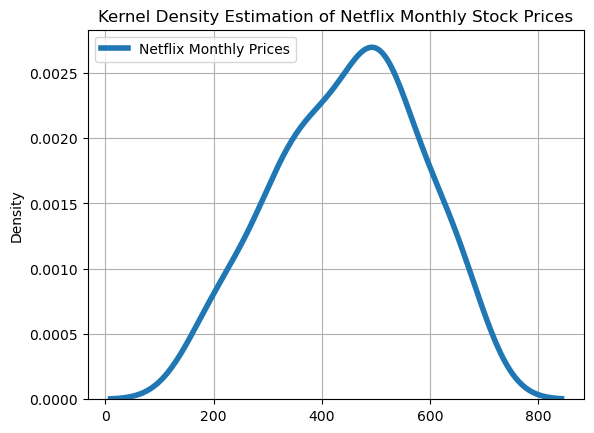

In [46]:
# Increase the data sampling frequency to monthly
nflx_monthly_data = nflx_data.resample('M').mean()
nflx_monthly_adj_close = nflx_monthly_data['Adj Close'].values

# Plot monthly data KDE
plt.figure(2)
sns.kdeplot(data = nflx_monthly_adj_close, linewidth = 4, label = "Netflix Monthly Prices")  # Add label for legend
plt.title("Kernel Density Estimation of Netflix Monthly Stock Prices")  # Add plot title
plt.legend()  # Show the legend
plt.grid(True)  # Optional: add a grid for clarity

plt.show()

<Figure size 1400x1000 with 0 Axes>

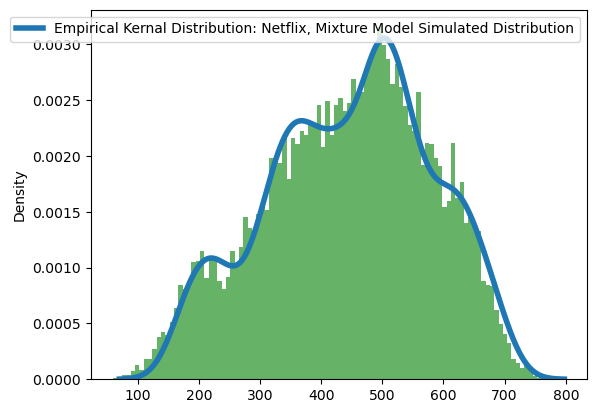

In [47]:
# Define parameters for the 4 normal distributions
mu_1, sigma1 = 210, 50
mu_2, sigma2 = 360, 60
mu_3, sigma3 = 505, 58
mu_4, sigma4 = 630, 45

# Probabilities for selecting each distribution
p1 = 0.12
p2 = 0.32
p3 = 0.41
p4 = 0.15

T = 10000

# Generate the data for r
r = np.zeros(T)

for t in range(T):
    # Draw random values from each distribution
    eps1 = np.random.normal(0, 1, 1)
    eps2 = np.random.normal(0, 1, 1)
    eps3 = np.random.normal(0, 1, 1)
    eps4 = np.random.normal(0, 1, 1)
    
    r1 = mu_1 + sigma1 * eps1
    r2 = mu_2 + sigma2 * eps2
    r3 = mu_3 + sigma3 * eps3
    r4 = mu_4 + sigma4 * eps4

    # Randomly select which distribution to sample from based on the probabilities
    u = np.random.uniform(0, 1, 1)
    
    if u <= p1:
        r[t] = r1
    elif u <= p1 + p2:
        r[t] = r2
    elif u <= p1 + p2 + p3:
        r[t] = r3
    else:
        r[t] = r4

# Plotting the histogram of r
plt.figure(figsize = (14,10))
fig, ax = plt.subplots()
sns.kdeplot(data = nflx_adj_close, linewidth = 4)
plt.hist(r, bins = 100, density = True, alpha = 0.6, color = 'green', label = "Histogram")
ax.legend(['Empirical Kernal Distribution: Netflix, Mixture Model Simulated Distribution'])

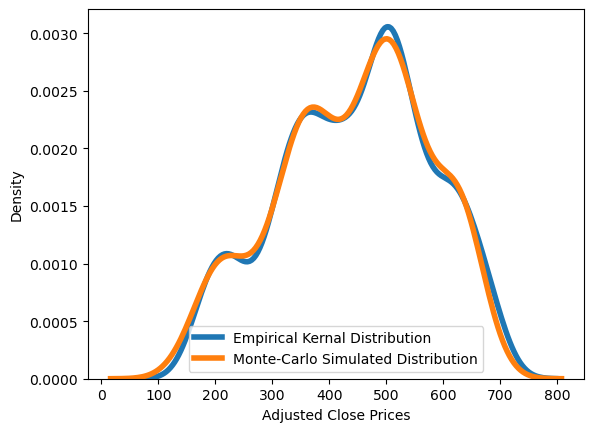

In [48]:
# Monte-Carlo analysis
mu_1, sigma1 = 210, 37
mu_2, sigma2 = 360, 48
mu_3, sigma3 = 505, 48
mu_4, sigma4 = 630, 30

p1 = 0.12
p2 = 0.32
p3 = 0.41
p4 = 0.15

def generateEmpiricalDist(mu_1, sigma1, mu_2, sigma2, mu_3, sigma3, mu_4, sigma4, p1, p2, p3, p4, T):
    #Normal Minflx_adj_closeture
    simulatedPrice = np.zeros(T-1);
    for t in range(0,T-1):
        r1 = mu_1 + sigma1*np.random.normal(0,1,1);
        r2 = mu_2 + sigma2*np.random.normal(0,1,1);
        r3 = mu_3 + sigma3*np.random.normal(0,1,1);
        r4 = mu_4 + sigma4*np.random.normal(0,1,1);
        u = np.random.uniform(0,1,1);
        if u <= p1:
            simulatedPrice[t] = r1
        elif u <= p1 + p2:
            simulatedPrice[t] = r2
        elif u <= p1 + p2 + p3:
            simulatedPrice[t] = r3
        else:
            simulatedPrice[t] = r4

    return simulatedPrice


T = nflx_adj_close.shape[0]
M = 1000
mu_mc = np.zeros(M)
y_mc = 0
for i in range(0, M):
    simulatedPrice = generateEmpiricalDist(mu_1, sigma1, mu_2, sigma2, mu_3, sigma3, mu_4, sigma4, p1, p2, p3, p4, T)
    mu_mc[i] = np.mean(simulatedPrice)
    y_mc += np.sort(simulatedPrice)

y_mc = y_mc/M

# Visualization
fig, anflx_adj_close = plt.subplots()
sns.kdeplot(data=nflx_adj_close, linewidth=4) # the blue line
sns.kdeplot(data=y_mc, linewidth=4) # the orange line
plt.xlabel("Adjusted Close Prices")
anflx_adj_close.legend(['Empirical Kernal Distribution', 'Monte-Carlo Simulated Distribution'])


# Kalman Filter Function

In [49]:
def kalman_filter(param,*args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]= Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        Likelihood += (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]      
    
    return Likelihood

# Kalman Smoother Function

In [50]:
def kalman_smoother(params, *args):
    # initialize params
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3] 
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]=Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth, P_smooth = {}, {}
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
    for t in range(S-1, 0, -1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[s])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
    
    # del u_update[-1]
    smooth_path = u_smooth
    return smooth_path 

## Kalman Filter Stock Price Prediction : Netflix

[*********************100%***********************]  1 of 1 completed


         Current function value: 4558.867391
         Iterations: 52
         Function evaluations: 492
         Gradient evaluations: 96
RMSE values is: $ 13.737083301259037


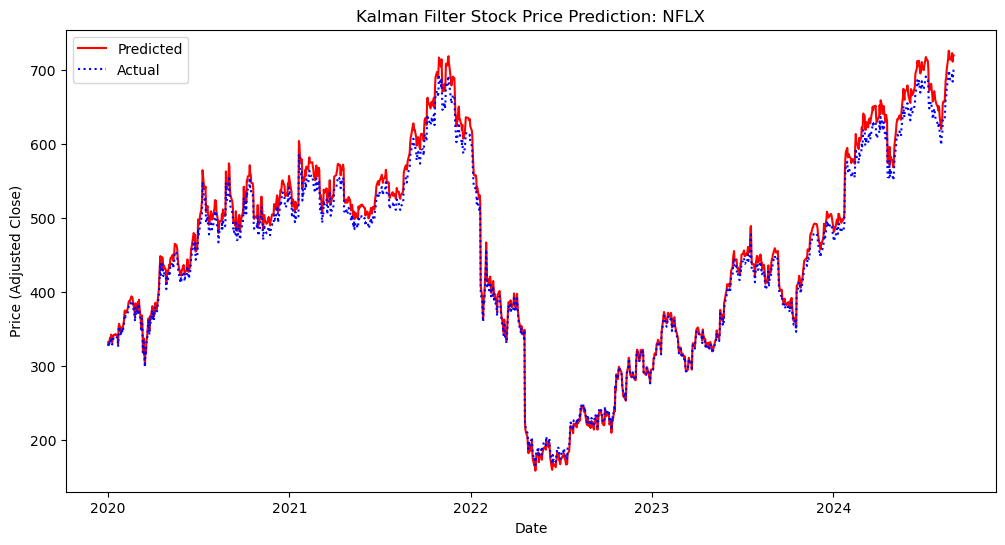

In [51]:
start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)
stock_symbol = 'NFLX'
stock = yf.download(stock_symbol,start_date ,end_date)
Y = stock['Adj Close'].values
S = Y.shape[0]
param0 = np.array([2.15, 0.99, np.var(Y)/2400, np.var(Y)/1400])
results = minimize(kalman_filter, param0, method='BFGS', tol=1e-7, options={'disp': True, 'maxiter': 2000})

# smoothe and visualize the estimated path
param_star = results.x
path = kalman_smoother(param_star, Y, S)
sorted_path = dict(sorted(path.items()))
Y_kalmanFilter = sorted_path.values()



# Extracting the dictionary values into a list (in the same order as keys)
kalman_values = list(Y_kalmanFilter)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(kalman_values) - np.array(Y))**2))

print('RMSE values is: $', RMSE)





# Plotting the results with actual dates
plt.figure(figsize=(12, 6))
plt.title('Kalman Filter Stock Price Prediction: ' + stock_symbol)


plt.plot(stock.index, kalman_values, 'r', label='Predicted')

# Plot the actual values in blue with a label
plt.plot(stock.index, Y, 'b:', label='Actual')


plt.xlabel("Date")
plt.ylabel("Price (Adjusted Close)")
plt.legend()

# main plot
plt.show()